# Statistical Analyses

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from analysis import MultiAnalysis, MultiRunAnalysis
from scipy.stats import ranksums, kruskal, wilcoxon
from statsmodels.stats.proportion import proportions_ztest


data_path = "../data"
save_path = "../figs"

### Confidence Interval Tables

In [2]:
exps = ['baseline', 'hidden500', 'hp_0', 'l1_0']

ma = MultiAnalysis(data_path, exps)
df = ma.get_confidence_intervals()

In [3]:
t = df.copy()

In [4]:
df = t.copy()
df = df.unstack(0).stack(0, future_stack=True)
df.index = df.index.swaplevel(0, 2)
df = df.sort_index()

active = df.loc[('active', ['proportion', 'IoU', 'turnover'], slice(None))]
place = df.loc[('place', ['proportion', 'IoU', 'turnover', 'remapping'], slice(None))]

remaps = pd.concat([active, place])
remaps.index = [remaps.index.get_level_values(0), remaps.index.map('{0[1]} ({0[2]})'.format)]
print(remaps.to_latex())

\begin{tabular}{llllll}
\toprule
 &  & baseline & hidden500 & hp_0 & l1_0 \\
\midrule
\multirow[t]{4}{*}{active} & proportion (trn) & 0.47$\pm$0.04 & 0.24$\pm$9.7e-03 & 1.00$\pm$0.00 & 0.45$\pm$0.03 \\
 & proportion (unt) & 0.56$\pm$0.06 & 0.24$\pm$0.04 & 1.00$\pm$0.00 & 0.55$\pm$0.08 \\
 & IoU (unt) & 0.69$\pm$0.03 & 0.49$\pm$0.05 & 1.00$\pm$0.00 & 0.63$\pm$0.04 \\
 & turnover (unt) & 0.38$\pm$0.06 & 0.45$\pm$0.07 & nan$\pm$nan & 0.46$\pm$0.09 \\
\cline{1-6}
\multirow[t]{5}{*}{place} & proportion (trn) & 0.41$\pm$0.04 & 0.22$\pm$0.01 & 0.00$\pm$0.00 & 0.39$\pm$0.03 \\
 & proportion (unt) & 0.33$\pm$0.06 & 0.16$\pm$0.04 & 0.00$\pm$0.00 & 0.34$\pm$0.07 \\
 & IoU (unt) & 0.37$\pm$0.06 & 0.24$\pm$0.04 & 0.00$\pm$0.00 & 0.34$\pm$0.05 \\
 & turnover (unt) & 0.80$\pm$0.08 & 0.78$\pm$0.06 & nan$\pm$nan & 0.84$\pm$0.09 \\
 & remapping (unt) & 0.97$\pm$0.03 & 0.98$\pm$0.03 & nan$\pm$nan & 0.97$\pm$0.03 \\
\cline{1-6}
\bottomrule
\end{tabular}



In [5]:
coverage = df.loc['place'].loc[['proportion', 'coverage', 'sizes']]
coverage.index = coverage.index.swaplevel(0, 1)
print(coverage.sort_index().to_latex())

\begin{tabular}{llllll}
\toprule
 &  & baseline & hidden500 & hp_0 & l1_0 \\
\midrule
\multirow[t]{3}{*}{trn} & coverage & 0.95$\pm$0.04 & 1.00$\pm$1.6e-03 & 0.00$\pm$0.00 & 0.94$\pm$0.04 \\
 & proportion & 0.41$\pm$0.04 & 0.22$\pm$0.01 & 0.00$\pm$0.00 & 0.39$\pm$0.03 \\
 & sizes & 0.06$\pm$6.8e-03 & 0.05$\pm$2.8e-03 & nan$\pm$nan & 0.06$\pm$6.7e-03 \\
\cline{1-6}
\multirow[t]{3}{*}{unt} & coverage & 0.52$\pm$0.08 & 0.68$\pm$0.08 & 0.00$\pm$0.00 & 0.53$\pm$0.07 \\
 & proportion & 0.33$\pm$0.06 & 0.16$\pm$0.04 & 0.00$\pm$0.00 & 0.34$\pm$0.07 \\
 & sizes & 0.02$\pm$3.4e-03 & 0.02$\pm$2.5e-03 & nan$\pm$nan & 0.02$\pm$2.7e-03 \\
\cline{1-6}
\bottomrule
\end{tabular}



### Miscellaneous Statistical Test

#### Hidden unit proportions

In [6]:
mra = MultiRunAnalysis(data_path, 'baseline')

In [7]:
trn = mra.df[mra.df.index.get_level_values(1) == 1].loc[(slice(None), slice(None), 'proportion')]
unt = mra.df[mra.df.index.get_level_values(1) != 1].loc[(slice(None), slice(None), 'proportion')]

In [8]:
ranksums(trn.place, unt.place, alternative='greater')

RanksumsResult(statistic=2.751433192971368, pvalue=0.002966756058953179)

In [9]:
ranksums(trn.active, unt.active, alternative='less')

RanksumsResult(statistic=-3.0231796811660705, pvalue=0.0012506683884259066)

#### Scales

In [10]:
trn = mra.df[mra.df.index.get_level_values(1) == 1].loc[(slice(None), slice(None), 'scales')].place
unt = mra.df[mra.df.index.get_level_values(1) != 1].loc[(slice(None), slice(None), 'scales')].place

In [11]:
mra.get_confidece_intervals().loc[(slice(None), 'scales'), ['place']]

,,place
trn,scales,0.30$\pm$0.02
unt,scales,0.13$\pm$0.03


In [12]:
ranksums(trn, unt)

RanksumsResult(statistic=3.3968311024337874, pvalue=0.0006817102933708383)

### Hidden Size

#### Proportions

In [13]:
mra = MultiRunAnalysis(data_path, 'hidden500')

In [14]:
df = mra.df.loc[(slice(None), slice(None), 'proportion'), :]
trn_ac = df.active.loc[(slice(None), 1, slice(None))]
unt_ac = df[df.index.get_level_values(1) != 1].active
trn_pc = df.place.loc[(slice(None), 1, slice(None))]
unt_pc = df[df.index.get_level_values(1) != 1].place

In [15]:
kruskal(trn_ac, unt_ac, trn_pc)

KruskalResult(statistic=3.2480258755297746, pvalue=0.1971061352387307)

In [16]:
wilcoxon(unt_pc, unt_ac, alternative='less')

WilcoxonResult(statistic=0.0, pvalue=4.4099351020972264e-05)

#### Coverage

In [17]:
hiddens = [f'hidden{n}' for n in [20, 50, 200, 500]]
hiddens.insert(2, 'baseline')

ma = MultiAnalysis(data_path, hiddens)

In [18]:
var = ['coverage', 'scales', 'sizes']
units = ['place']
how = 'trn'

{v: kruskal(*data) for v, data in ma.get_data_for_statistical_test(var, units, how).items()}

{'coverage': KruskalResult(statistic=20.869565217391315, pvalue=0.0003360929523211246),
 'scales': KruskalResult(statistic=22.45661538461539, pvalue=0.00016254525126029832),
 'sizes': KruskalResult(statistic=21.76984615384616, pvalue=0.00022270724572620365)}

In [19]:
var = ['coverage', 'scales', 'sizes']
units = ['place']
how = 'unt'

{v: kruskal(*data) for v, data in ma.get_data_for_statistical_test(var, units, how).items()}

{'coverage': KruskalResult(statistic=84.36201980198018, pvalue=2.0716336375048657e-17),
 'scales': KruskalResult(statistic=90.21445544554456, pvalue=1.1856292809450757e-18),
 'sizes': KruskalResult(statistic=40.418019801980165, pvalue=3.5469813921092296e-08)}

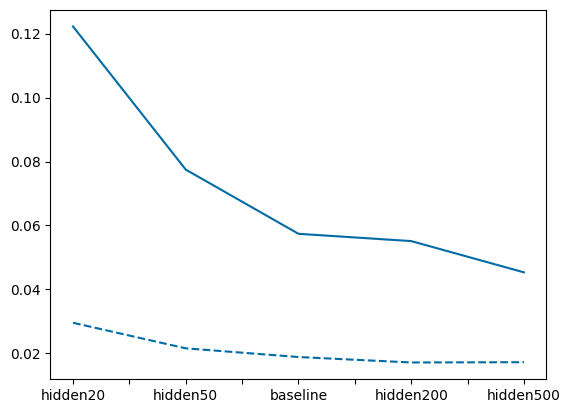

In [20]:
df = ma.coverage_stats().loc[:, 'place']
ax = df.loc[('trn', 'sizes')].T.plot()
ax.set_prop_cycle(None)
df.loc[('unt', 'sizes')].T.plot(ax=ax, linestyle='--')
plt.show()

### Remapping

In [21]:
hiddens = [f'hidden{n}' for n in [20, 50, 200, 500]]
hiddens.insert(2, 'baseline')

ma = MultiAnalysis(data_path, hiddens)

In [22]:
var = ['remapping', 'turnover']
units = ['place']
how = 'unt'

{v: kruskal(*data) for v, data in ma.get_data_for_statistical_test(var, units, how).items()}

{'remapping': KruskalResult(statistic=1.7165958247132012, pvalue=0.7877008095964222),
 'turnover': KruskalResult(statistic=33.8672920755532, pvalue=7.933769175432972e-07)}

In [23]:
var = ['turnover']
units = ['active']
how = 'unt'

{v: kruskal(*data) for v, data in ma.get_data_for_statistical_test(var, units, how).items()}

{'turnover': KruskalResult(statistic=56.2903289125625, pvalue=1.742917757247385e-11)}

# Move to another file